## Motivation:
Repeat the `250312_blue_shrew_long` experiment on virtualised infrastructure.

## Attack:
- Shrew attack with an RPS of 100.
- Commenced *after 15 minutes of 'normal operation'*.

## Policy:
- "blue -t 10.0 -f 0.8 -i 0.05 -s 5.0 -e 300"
- Exploration for 300 steps @ 10s per step = 50 mins

In [65]:

import plot_utils
from plot_utils import LogFile,LogFileType,Fig,Roller
import rolling_funcs

WINDOW_SECS=120.0
STRIDE_SECS=5.0
# WINDOW_SECS=3.0
# STRIDE_SECS=-1.0

In [66]:

response_rollers = [
    Roller("OK rate", rolling_funcs.count_ok, rate=True),
    Roller("ERR rate", rolling_funcs.count_err, rate=True, kwargs={'linestyle':'--'}),
]
mean_roller = Roller('mean', rolling_funcs.mean)
packet_rate = Roller('rate', rolling_funcs.count_kleene_packets, rate=True)

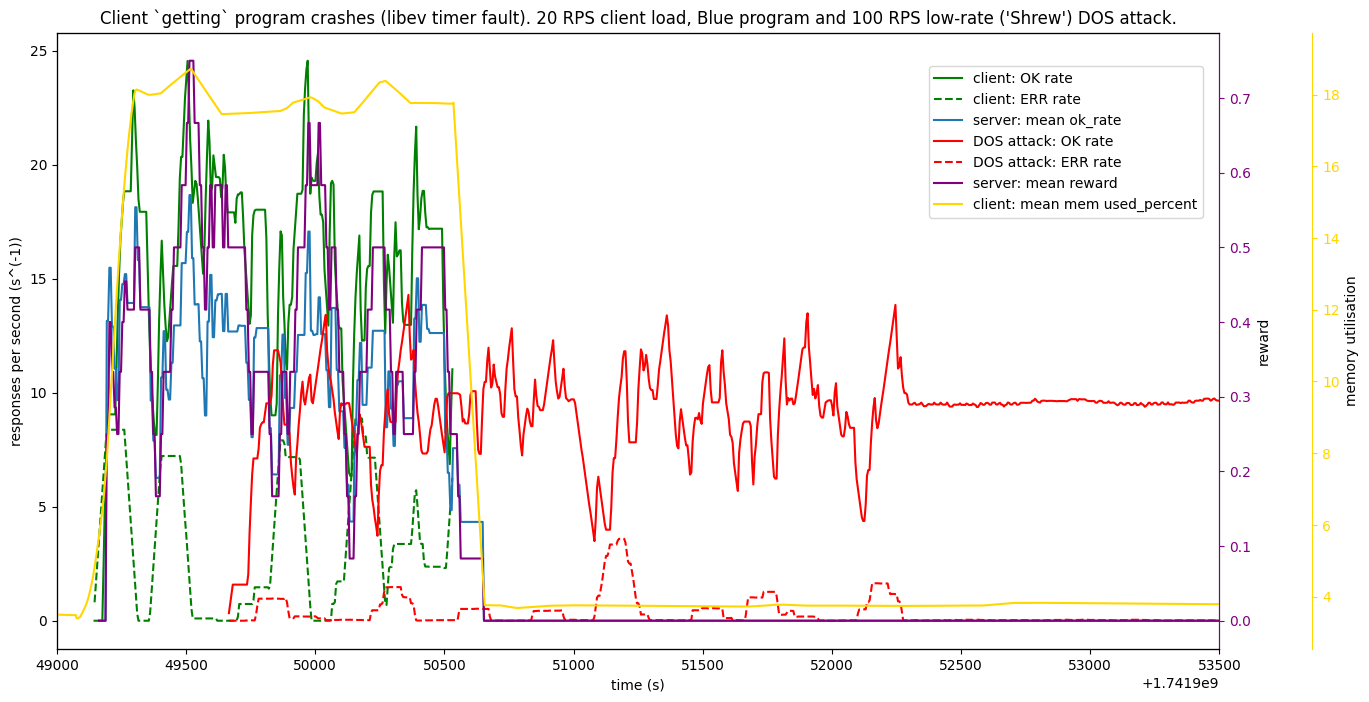

In [67]:
HILBERT="./logs/hilbert/2025-03-14_12:29:27.json"
HILBERT_BLUE="./logs/hilbert/2025-03-14_10-45-58.197082.txt"
KLEENE="./logs/kleene/2025-03-14_10-45-40.831981.txt"
KLEENE_TELEGRAF="./logs/kleene/2025-03-14_12:29:27.json"
MAC="./logs/mac/2025-03-14_10-54-20.850222.txt"

fig,ax = plot_utils.fig([Fig(title="Client `getting` program crashes (libev timer fault). 20 RPS client load, Blue program and 100 RPS low-rate ('Shrew') DOS attack.",x='time (s)',y='responses per second (s^(-1))')])
ax.set_xlim(49000+1.7419e9,53500+1.7419e9)
# ax.set_xlim(50400+1.7419e9,50600+1.7419e9)

nginx_active = LogFile(log_type=LogFileType.TELEGRAF, path=HILBERT,
kwargs={'telegraf': {
    'nginx' : ['active', 'waiting']
}
})

client_mem = LogFile(log_type=LogFileType.TELEGRAF, path=KLEENE_TELEGRAF,
kwargs={'telegraf':{
    # 'mem' : ['used_percent','buffered','cached','vmalloc_used']
    'mem' : [{'used_percent':{'color':'gold'}}]
}})

client_log = LogFile(log_type=LogFileType.GOT, path=KLEENE,kwargs={'color':'g'})
shrew_log = LogFile(log_type=LogFileType.GOT, path=MAC,kwargs={'color':'r'})

blue_reward = LogFile(log_type=LogFileType.BLUE, path=HILBERT_BLUE,
kwargs={'states': [{'reward':{'color':'purple'}}]})

blue_ok_rate = LogFile(log_type=LogFileType.BLUE, path=HILBERT_BLUE,
kwargs={'states': ['ok_rate']})

# blue_actions = LogFile(log_type=LogFileType.BLUE, path=HILBERT_BLUE,
# kwargs={'actions': True
# })

ax_reward, ax_mem = plot_utils.add_y_axes(
    ax, [('reward','purple'), ('memory utilisation','gold')]
)

# plot_utils.overlay_rolling(ax_active, {'server': nginx_active}, [mean_roller],WINDOW_SECS,times_units='s')
plot_utils.overlay_rolling(ax_reward, {'server': blue_reward}, [mean_roller],WINDOW_SECS, const_stride_secs=STRIDE_SECS, times_units='s')
plot_utils.overlay_rolling(ax_mem, {'client': client_mem}, [mean_roller],WINDOW_SECS,times_units='s')
plot_utils.overlay_rolling(ax, {'client': client_log}, response_rollers, WINDOW_SECS, const_stride_secs=STRIDE_SECS, times_units='s')
plot_utils.overlay_rolling(ax, {'server': blue_ok_rate}, [mean_roller],WINDOW_SECS, const_stride_secs=STRIDE_SECS, times_units='s')
plot_utils.overlay_rolling(ax, {'DOS attack': shrew_log}, response_rollers, WINDOW_SECS, const_stride_secs=STRIDE_SECS, times_units='s')

plot_utils.show_combined_legends([ax,ax_reward,ax_mem], loc=[0.75,0.7])
fig.savefig('./plots/20RPS_DOS_virtual_client_crash.png')

## Client `getting` program crash:
The following exception occured in the `getting` program running on the client:
`- getting: ev.c:4421: ev_timer_stop: Assertion `("libev: internal timer heap corruption", ANHE_w (timers [active]) == (WT)w)' failed.`

Potentially caused by passing `Lwt.t` promises between system threads. Various issues ([[1]](https://github.com/yugabyte/yugabyte-db/issues/1859),[[2]](https://github.com/ocsigen/lwt/issues/168)) suggest this could be a problem. The exception seems to occur infrequently, so a reasonable workaround was to set up auto-restart for the systemd services running the `getting` program (this change has been pushed to both physcial and virtual infras). 

Below the experiment is re-run.

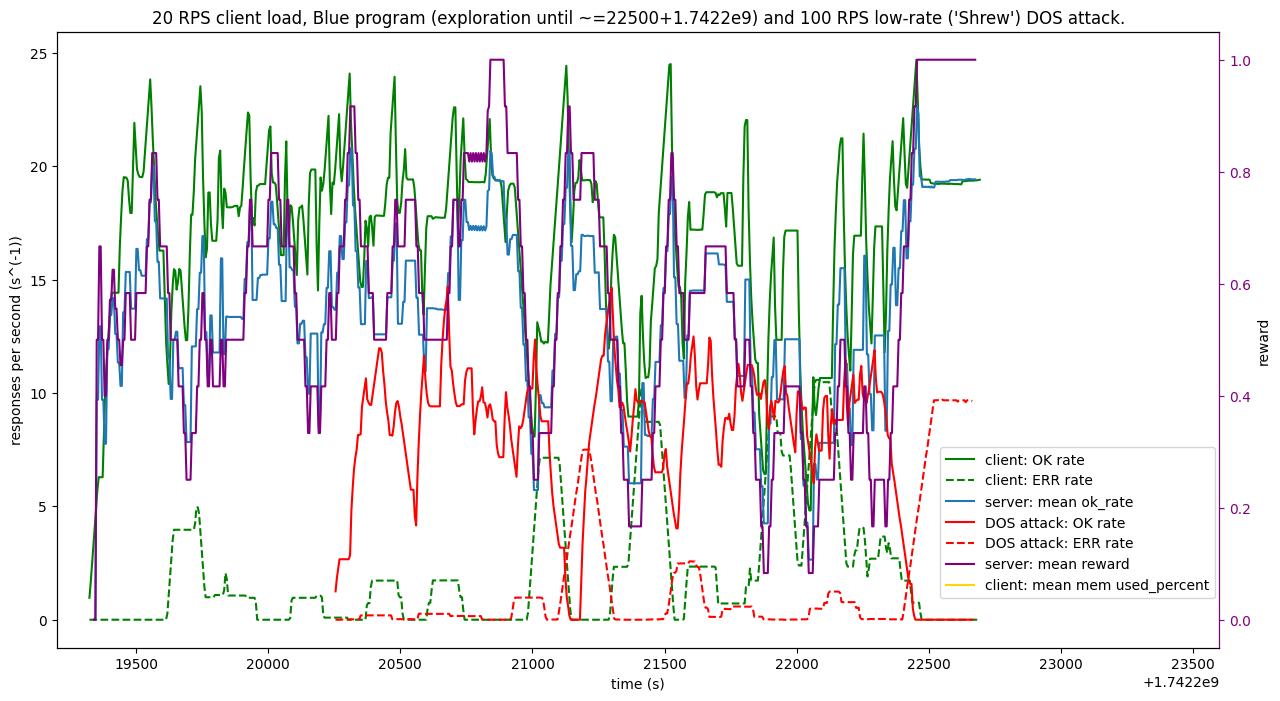

In [68]:
HILBERT="./logs/hilbert/2025-03-17_14:45:30.json"
HILBERT_BLUE="./logs/hilbert/2025-03-17_13-48-55.730635.txt"
KLEENE="./logs/kleene/2025-03-17_13-48-38.101165.txt"
KLEENE_TELEGRAF="./logs/kleene/2025-03-17_14:45:30.json"
MAC="./logs/mac/2025-03-17_14-04-09.642198.txt"

fig,ax = plot_utils.fig([Fig(title="20 RPS client load, Blue program (exploration until ~=22500+1.7422e9) and 100 RPS low-rate ('Shrew') DOS attack.",x='time (s)',y='responses per second (s^(-1))')])
ax.set_xlim(19200+1.7422e9,(23600+1.7422e9))
# ax.set_xlim(50400+1.7419e9,50600+1.7419e9)

nginx_active = LogFile(log_type=LogFileType.TELEGRAF, path=HILBERT,
kwargs={'telegraf': {
    'nginx' : ['active', 'waiting']
}
})

client_mem = LogFile(log_type=LogFileType.TELEGRAF, path=KLEENE_TELEGRAF,
kwargs={'telegraf':{
    # 'mem' : ['used_percent','buffered','cached','vmalloc_used']
    'mem' : [{'used_percent':{'color':'gold'}}]
}})

client_log = LogFile(log_type=LogFileType.GOT, path=KLEENE,kwargs={'color':'g'})
shrew_log = LogFile(log_type=LogFileType.GOT, path=MAC,kwargs={'color':'r'})

blue_reward = LogFile(log_type=LogFileType.BLUE, path=HILBERT_BLUE,
kwargs={'states': [{'reward':{'color':'purple'}}]})

blue_ok_rate = LogFile(log_type=LogFileType.BLUE, path=HILBERT_BLUE,
kwargs={'states': ['ok_rate']})

# blue_actions = LogFile(log_type=LogFileType.BLUE, path=HILBERT_BLUE,
# kwargs={'actions': True
# })

[ ax_reward,
# ax_mem 
] = plot_utils.add_y_axes(
    ax, [('reward','purple'),
        #  ('memory utilisation','gold')
         ]
)

# plot_utils.overlay_rolling(ax_active, {'server': nginx_active}, [mean_roller],WINDOW_SECS,times_units='s')
plot_utils.overlay_rolling(ax_reward, {'server': blue_reward}, [mean_roller],WINDOW_SECS, const_stride_secs=STRIDE_SECS, times_units='s')
# plot_utils.overlay_rolling(ax_mem, {'client': client_mem}, [mean_roller],WINDOW_SECS,times_units='s')
plot_utils.overlay_rolling(ax, {'client': client_log}, response_rollers, WINDOW_SECS, const_stride_secs=STRIDE_SECS, times_units='s')
plot_utils.overlay_rolling(ax, {'server': blue_ok_rate}, [mean_roller],WINDOW_SECS, const_stride_secs=STRIDE_SECS, times_units='s')
plot_utils.overlay_rolling(ax, {'DOS attack': shrew_log}, response_rollers, WINDOW_SECS, const_stride_secs=STRIDE_SECS, times_units='s')

plot_utils.show_combined_legends([ax,ax_reward,ax_mem], loc=[0.76,0.08])
fig.savefig('./plots/20RPS_DOS_virtual.png')

In [69]:
from blue import Blue
blue = Blue(HILBERT_BLUE)
end_of_exploration = (1.7422e9+22400) 
blue.stats(sorted=True,end_ns=end_of_exploration*1e9)

[('red_blocked', 97),
 ('none_blocked', 68),
 ('both_blocked', 0),
 ('green_blocked', 0)]

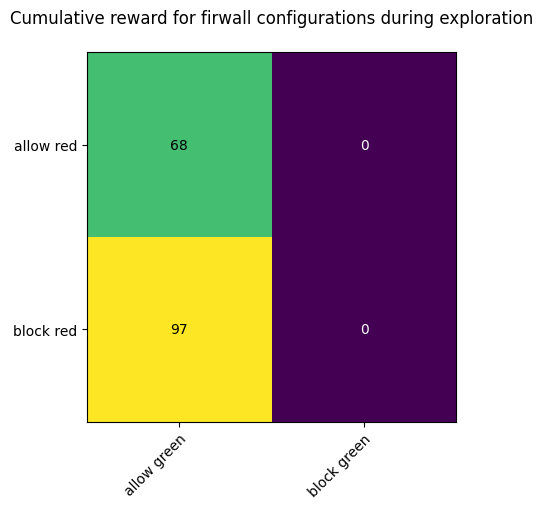

In [70]:
fig,ax = blue.heatmap(title="Cumulative reward for firwall configurations during exploration\n", end_ns=end_of_exploration*1e9)
fig.savefig('./plots/policy_heatmap.png')